### All modifications - repeat 10 times, more epochs and samples

This experiment involves the default setup for all the parameters, however with the reduced dataset size to 15000, as explained in the write up. The expeirment is repeated 10 times, and here, we are interested in measurement consistency, i.e. throughput dispersion between different experiments. 
Also, we consider two different execution environments, IARAI and TU.

In [3]:
from benchmarking.analysis.analyze_results import *

In [4]:
# dataset size
samples = 300

Data loading function:

In [32]:
def load_all_experiments(output_base_folder, base_folder):
    results_scratch = []
    results_s3 = []
#     for folder_index in range(1, 11):
#     print(f"Working with {folder_index}")
    s3_folder_filter= base_folder + "*benchmark_e2e*"
    scratch_folder_filter= base_folder + "*benchmark_e2e*"

    print(s3_folder_filter)
    # read data
    df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
    df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)

    # Get unique functions 
    unique_functions_scratch = np.unique(df_dataloader_scratch["item_x"])
    print(f"Unique functions: {unique_functions_scratch}")

    unique_runs_scratch = np.unique(df_dataloader_scratch["run"])
    unique_runs_s3 = np.unique(df_dataloader_s3["run"])

    # extract GPU UTIL
    df_gpuutil_scratch = extract_gpuutil(output_base_folder, folder_filter=scratch_folder_filter)
    unique_runs_scratch = np.unique(df_dataloader_scratch["run"])

    df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)
    unique_runs_s3 = np.unique(df_dataloader_s3["run"])

    # Get data for scratch
    returns_scratch = []
    for run in sorted(unique_runs_scratch):
        df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
        dfgpu = df_gpuutil_scratch[df_gpuutil_scratch["run"]==run]
        returns_scratch.append(get_gpu_stats(df, dfgpu, run, False, True, False, 2))
    result = pd.DataFrame.from_records(data=returns_scratch)
    result["throughput"] = samples / result["runtime"]
    results_scratch.append(result)

    # Get data for S3
    returns_s3 = []
    for run in sorted(unique_runs_s3):
        df = df_dataloader_s3[df_dataloader_s3["run"]==run]
        dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
        returns_s3.append(get_gpu_stats(df, dfgpu, run, False, True, False, 2))
    result = pd.DataFrame.from_records(data=returns_s3)
    result["throughput"] = samples / result["runtime"]
    results_s3.append(result)
    return results_s3, results_scratch

In [49]:
impls = ["threaded", "asyncio"]
libs = ["torch", "lightning"]

In [44]:
def add_stats(throughputs):
    df = throughputs.T

    mean = df.mean(axis=1)
    var = df.var(axis=1)
    std = df.std(axis=1)

    df["mean"] = mean.round(2)
    df["var"] = var.round(2)
    df["std"] = std.round(2)
    return df

### TU environment

In [35]:
# setup folders
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/repeated_long_e2e/")
base_folder = "fetchers_test2/s3/"

# Load data
results_s3, results_scratch = load_all_experiments(output_base_folder, base_folder)

fetchers_test2/s3/*benchmark_e2e*


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 603/603 [00:01<00:00, 367.09it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 603/603 [00:00<00:00, 13083.67it/s]


In [45]:
# Check the sizes
print(f"Experiments loaded ... S3: {len(results_s3)}, Scratch: {len(results_scratch)}")

Experiments loaded ... S3: 1, Scratch: 1


In [69]:
results_s3

[       runtime  gpu_util_zero  gpu_util_mean_no_zeros  mem_util_mean  \
 0   149.219473      68.844221               52.483871       9.427136   
 1   141.125163      44.927536               50.157895       7.444444   
 2   197.152493      82.578397               50.160000       5.191638   
 3    77.242551      90.082645               47.250000       2.471074   
 4    83.250795      82.677165               32.545455       1.433071   
 5    84.564497      91.735537               37.600000       1.619835   
 6    81.775032      87.500000               28.642857       0.892857   
 7    70.836919      91.089109               45.000000       2.039604   
 8    80.427738      83.478261               26.578947       1.182609   
 9    73.383414      91.836735               45.625000       1.948980   
 10   81.371472      86.290323               32.882353       1.225806   
 11   83.626803      91.538462               64.000000       2.753846   
 12   89.420664      83.846154               31.000

In [82]:
def plot_all_histograms_tmp(res, impls, libs, display=True):
    foo = 0
    df_throughput_all = pd.DataFrame()
    for impl in impls:
        for lib in libs:
            throughput = []
            key = f"{impl}_{lib}_{foo}"
            foo = foo + 1
            print(f"Using key: {key}")
            for experiment in range(len(res)):
                data = res[experiment].round(2)
                data = data[(data["library"] == lib) & (data["implementation"] == impl)]["throughput"]
                throughput.append(data)
#               k = pd.DataFrame.from_records(throughput)
            df_throughput_all.append(pd.DataFrame.from_records(throughput))
#             if display:
#                 plot_histogram(throughput, f"Setup: {impl}, {lib}")
    return df_throughput_all

In [83]:
throughput_all_s3 = plot_all_histograms_tmp(results_s3, impls, libs, True) # display = False (doesn't plot histogrms)

Using key: threaded_torch_0
Using key: threaded_lightning_1
Using key: asyncio_torch_2
Using key: asyncio_lightning_3


In [85]:
throughput_all_scratch = plot_all_histograms(results_scratch, impls, libs, True) # display = False (doesn't plot histogrms)

ValueError: Wrong number of items passed 4, placement implies 1

In [86]:
df_t_s3 = add_stats(throughput_all_s3)
df_t_s3

,mean,var,std


In [87]:
df_t_scratch = add_stats(throughput_all_scratch)
df_t_scratch

NameError: name 'throughput_all_scratch' is not defined

ValueError: zero-size array to reduction operation minimum which has no identity

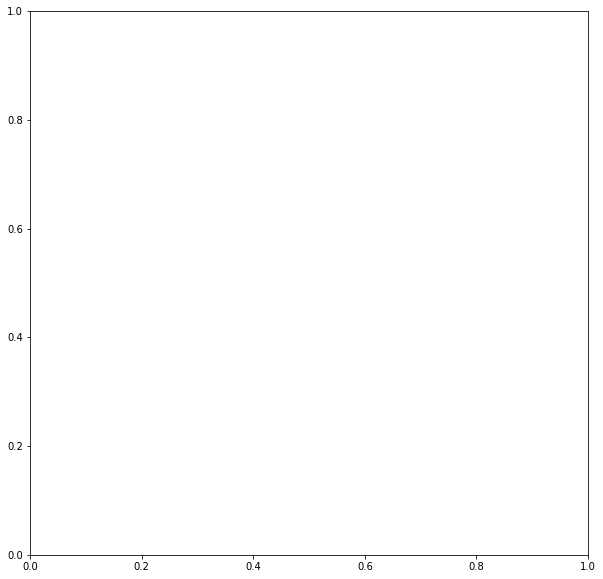

In [62]:
plot_violins(df_t_s3, "TU Remote storage - AWS S3")

In [63]:
plot_violins(df_t_scratch, "TU Local storage")

NameError: name 'df_t_scratch' is not defined

Concave?

In [6]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/repeated_long_e2e/1612_run_1/s3/")
df_dataset = extract_pandas(output_base_folder, folder_filter="**/*benchmark_e2e*")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [02:39<00:00,  6.03it/s]


In [7]:
group_by_dataset=["dataset", "pool_size"]
experiment_thr = "20211217f162804_benchmark_e2e_torch_s3_256_4_16_1_threaded_sync"
experiment_vnl = "20211217f223227_benchmark_e2e_torch_s3_256_4_16_1_vanilla_sync"
experiment_asy = "20211217f192444_benchmark_e2e_torch_s3_256_4_16_1_asyncio_sync"
experiments = [experiment_thr, experiment_vnl, experiment_asy]

output_base_folder_timeline_dataset_thr = output_base_folder / experiment_thr
output_base_folder_timeline_dataset_vnl = output_base_folder / experiment_vnl
output_base_folder_timeline_dataset_asy = output_base_folder / experiment_asy

In [8]:
with (output_base_folder_timeline_dataset_thr / "metadata.json").open() as f:
    metadata = json.load(f)
print(metadata)

{'arch': 'resnet18', 'num_workers': 4, 'epochs': 80, 'start_epoch': 0, 'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0001, 'print_freq': 10, 'resume': '', 'evaluate': False, 'pretrained': False, 'world_size': -1, 'rank': -1, 'dist_url': 'tcp://224.66.41.62:23456', 'dist_backend': 'nccl', 'gpu': 2, 'multiprocessing_distributed': False, 'seed': 42, 'fetch_impl': 'threaded', 'dataset_limit': 35000, 'num_fetch_workers': 16, 'prefetch_factor': 2, 'dataset': 's3', 'output_base_folder': '1612_run_1', 'batch_size': 256, 'pin_memory': 0, 'use_cache': 1, 'batch_pool': 512, 'num_sanity_val_steps': 0, 'distributed': False, 'system': 'Linux', 'node': 'tu-fat-1', 'release': '4.19.0-18-amd64', 'version': '#1 SMP Debian 4.19.208-1 (2021-09-29)', 'machine': 'x86_64', 'processor': ''}


### S3

In [64]:
for experiment in experiments:
    df = df_dataset[df_dataset["run"]==experiment]
    df = df[df["function_name"]=="__getitem__"] #[:30000]
    print(len(df))
    # display(df.head())
    df.plot.scatter(x="time_start", y="elapsed", ylim=(0, 10), figsize=(55,15))
#     df.plot.scatter(x="time_end", y="elapsed", ylim=(0, 10), xlim=(0, 1639765646.5023496), figsize=(55,15))
#     break

NameError: name 'experiments' is not defined

In [65]:
df["time_end"][50000]

NameError: name 'df' is not defined

In [133]:
# fig, axes = plt.subplots(nrows=1, ncols=1)
# df.hist(column="time_end", bins=int(df["time_end"].max()-df["time_start"].min())*10, ax=axes)
# axes.axvline(df["time_start"].min(), color="red")
# axes.axvline(df["time_end"].max(), color="red")
# fig.suptitle("throughput [#/ds]")

In [134]:
# fig, axes = plt.subplots(nrows=1, ncols=1)
# df.hist(column="time_start", bins=int(df["time_end"].max()-df["time_start"].min())*10, ax=axes)
# axes.axvline(df["time_start"].min(), color="red")
# axes.axvline(df["time_end"].max(), color="red")
# fig.suptitle("throughput [#/ds]")

In [94]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/repeated_long_e2e/fetchers_test2/s3")
df_dataset = extract_pandas(output_base_folder, folder_filter="**/*benchmark_e2e*")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 603/603 [00:06<00:00, 88.32it/s]


In [98]:
runs = np.unique(df_dataset["run"])

In [92]:
# output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/repeated_long_e2e/1612_run_1/scratch/")
group_by_dataset=["dataset", "pool_size"]
experiment_thr = "20220107f161320_benchmark_e2e_torch_s3_128_4_1_1_threaded_sync"
experiment_vnl = "20220107f161826_benchmark_e2e_torch_s3_128_4_1_1_asyncio_sync"
experiments = [experiment_thr, experiment_asy]

output_base_folder_timeline_dataset_thr = output_base_folder / experiment_thr
output_base_folder_timeline_dataset_asy = output_base_folder / experiment_asy

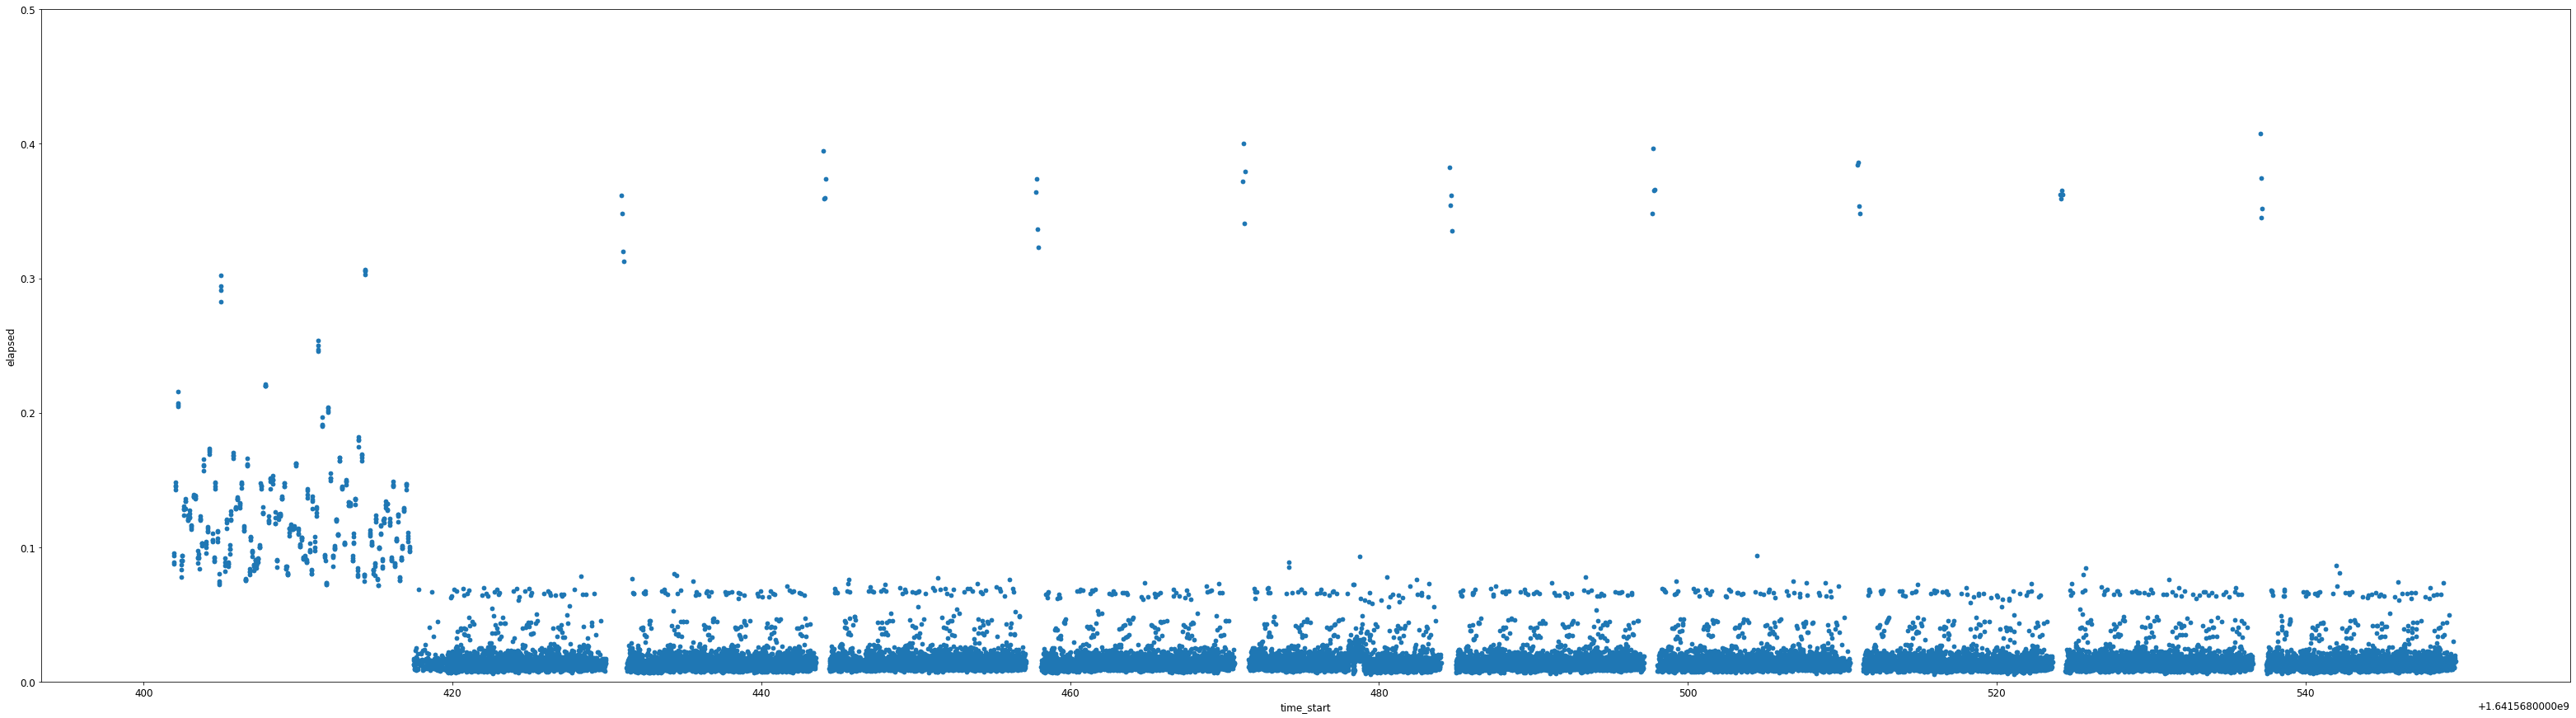

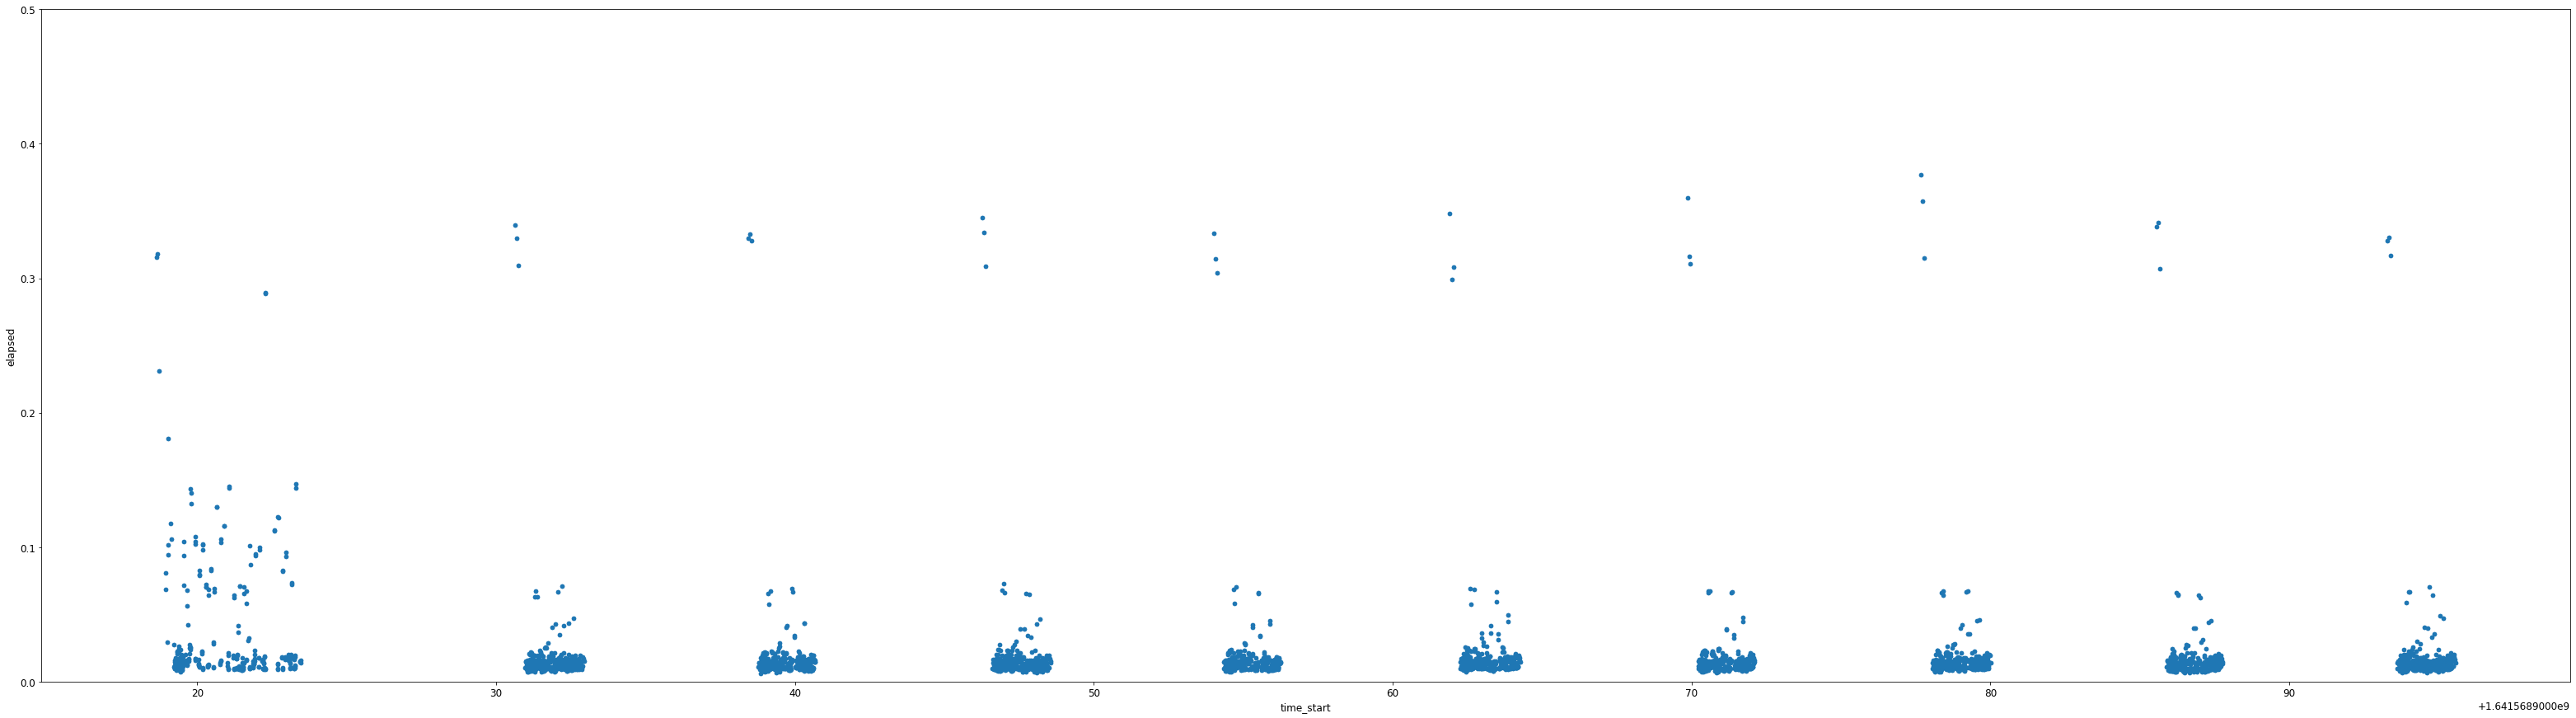

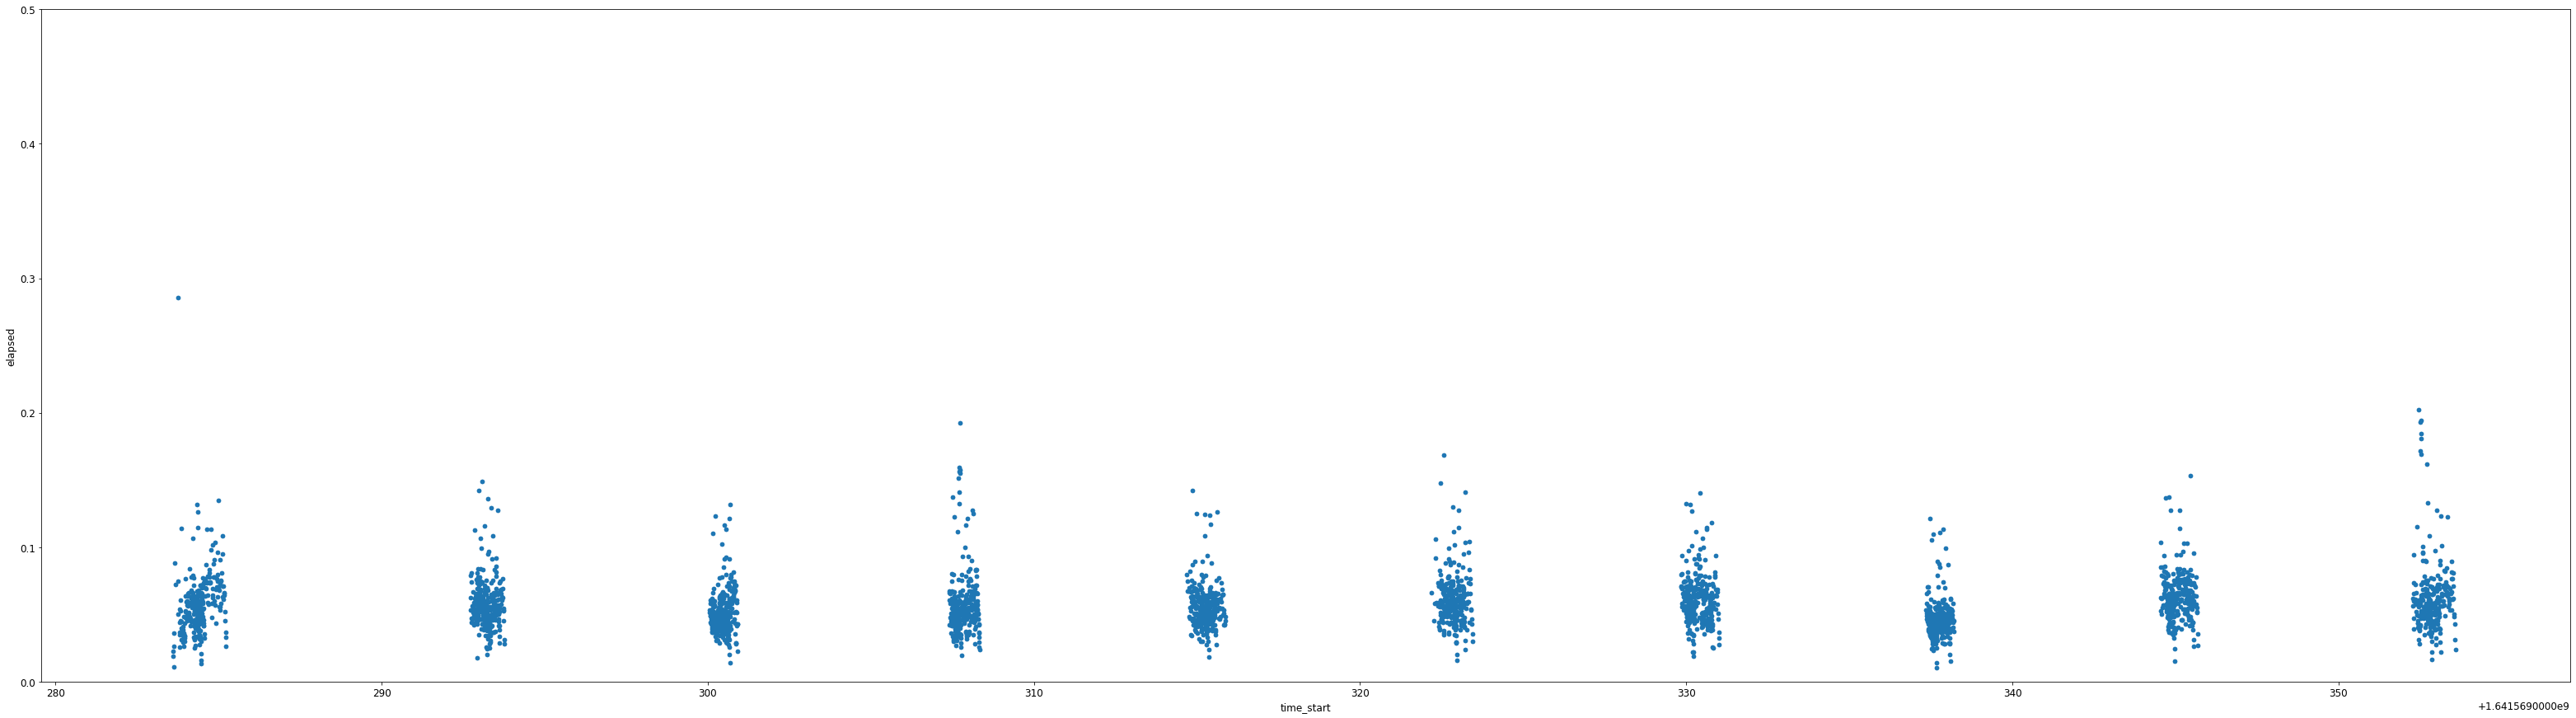

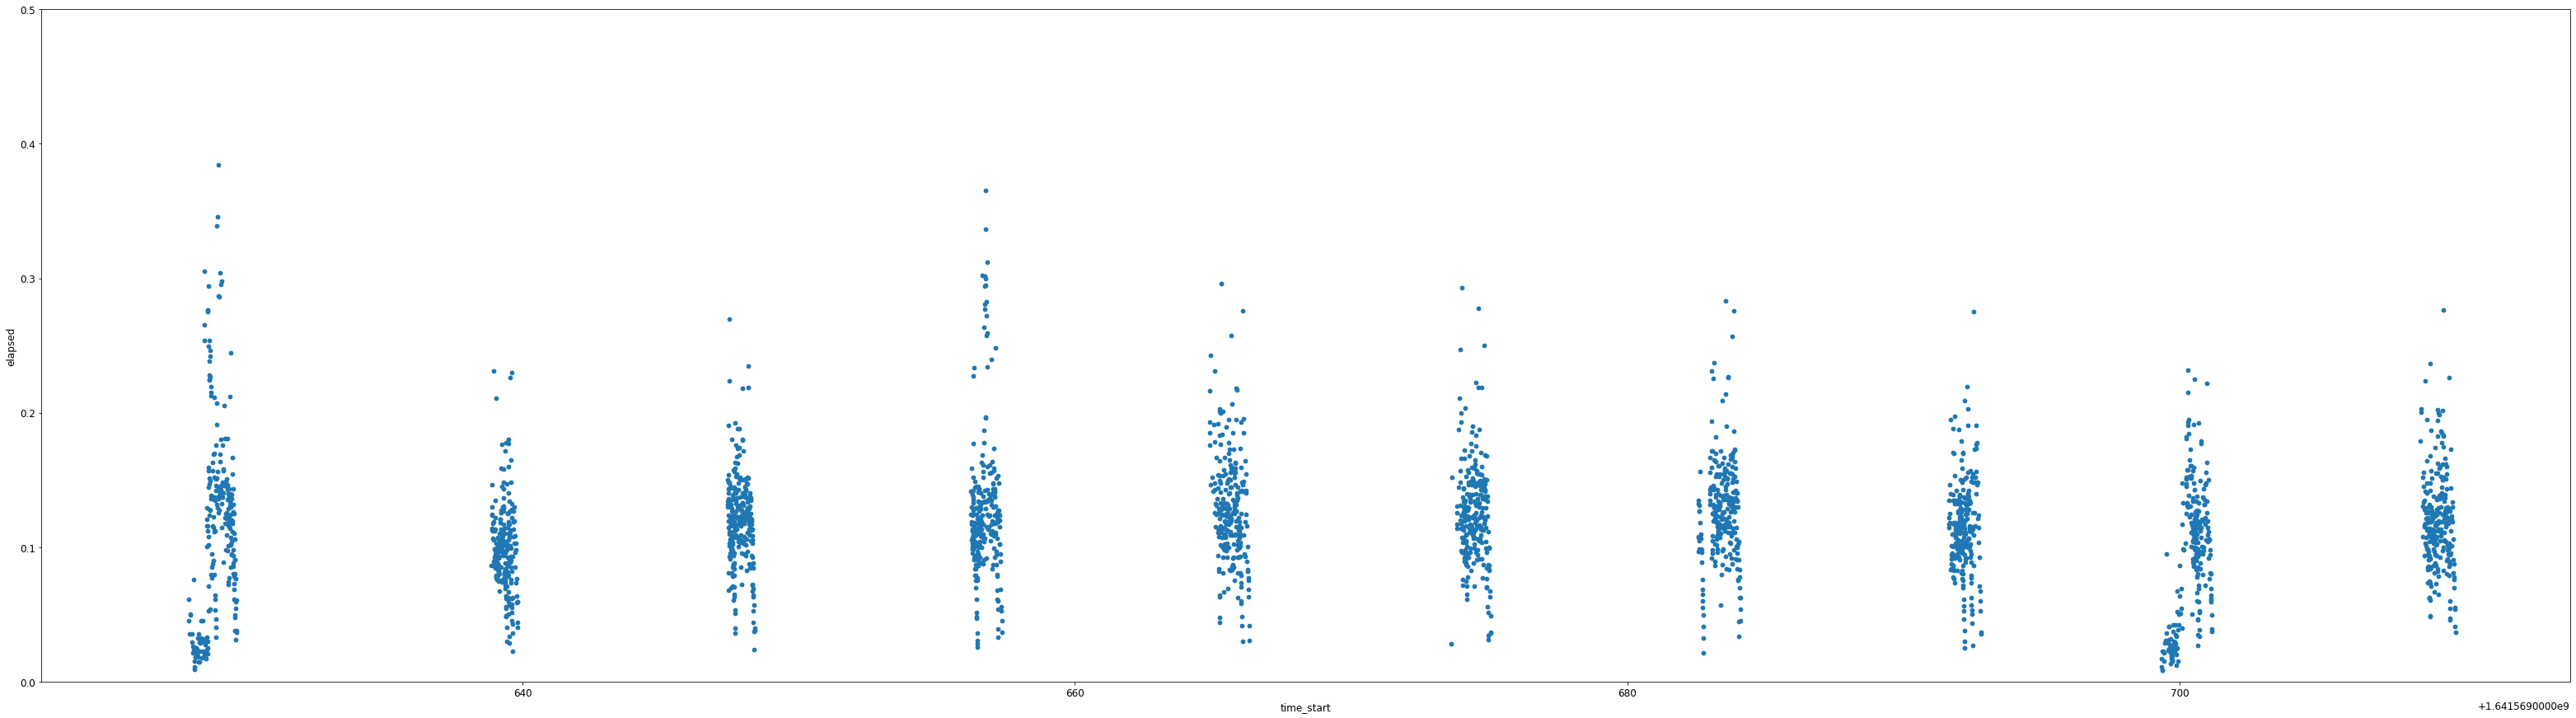

In [102]:
for experiment in runs:
    if "threaded" in experiment and "torch" in experiment:
        df = df_dataset[df_dataset["run"]==experiment]
        df = df[df["function_name"]=="__getitem__"]
        # display(df.head())
        df.plot.scatter(x="time_start", y="elapsed", ylim=(0, 0.5), figsize=(55,15))
    #     df.plot.scatter(x="time_end", y="elapsed", figsize=(55,15))    

In [117]:
# df = df_dataset[df_dataset["run"]==experiment]
# unique_functions = np.unique(df["function_name"])

In [118]:
# unique_functions

array(['__getitem__', 'fetch'], dtype=object)